In [187]:
from fastai.vision.all import *
from utils import *

from fastai.imports import *
from fastai.vision.widgets import *
# to easier work with paths
from pathlib import Path
matplotlib.rc('image', cmap='Greys')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fastbook
fastbook.setup_book()
from fastbook import *
from sklearn.metrics import accuracy_score
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG

from fastai.tabular.all import *
from dtreeviz.trees import *
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
path = Path()
path.ls()

(#9) [Path('.ipynb_checkpoints'),Path('models'),Path('TytanicClassifier2.ipynb'),Path('TytanicTrainClassifier.html'),Path('TytanicTrainClassifier.ipynb'),Path('submission_nar_titanic.csv'),Path('test.csv'),Path('train.csv'),Path('TytanicClassifier3.ipynb')]

In [65]:
df_nn = pd.read_csv(path/'train.csv', low_memory=False)
df_test = pd.read_csv(path/'test.csv', low_memory=False)

In [7]:
df_nn

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",...,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",...,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",...,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",...,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",...,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",...,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",...,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",...,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",...,111369,30.0000,C148,C


In [8]:
dep_var = 'Survived'

In [9]:
cont_nn,cat_nn = cont_cat_split(df_nn, max_card=9000, dep_var=dep_var)

In [11]:
cont_nn,cat_nn

(['Age', 'Fare'],
 ['PassengerId',
  'Pclass',
  'Name',
  'Sex',
  'SibSp',
  'Parch',
  'Ticket',
  'Cabin',
  'Embarked'])

In [12]:
df_nn[cat_nn].nunique()


PassengerId    891
Pclass           3
Name           891
Sex              2
SibSp            7
Parch            7
Ticket         681
Cabin          147
Embarked         3
dtype: int64

In [182]:
df_nn['Survived'] = df_nn['Survived'].astype(np.float32)

In [15]:
cond = df_nn.PassengerId<660
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [183]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [184]:
len(to_nn.train),len(to_nn.valid)

(659, 232)

In [185]:
dls = to_nn.dataloaders()

In [186]:
y = to_nn.train.y
y.min(),y.max()

(0.0, 1.0)

In [188]:
learn1 = tabular_learner(dls, y_range=(0,1), layers=[300,150],
                        n_out=1, loss_func=F.mse_loss,metrics=accuracy)

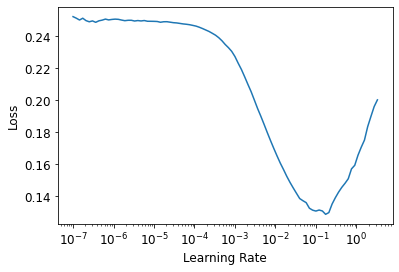

In [189]:
lrmin, lrsteep = learn1.lr_find()

In [190]:
learn1.fine_tune(5, lrsteep)

epoch,train_loss,valid_loss,accuracy,time
0,0.228595,0.240010,0.637931,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.064236,0.242855,0.637931,00:00
1,0.033265,0.236616,0.637931,00:00
2,0.021437,0.176957,0.637931,00:00
3,0.014588,0.160445,0.637931,00:00
4,0.010444,0.153086,0.637931,00:00


In [142]:
learn2 = tabular_learner(dls, y_range=(0,1), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss, metrics=accuracy)

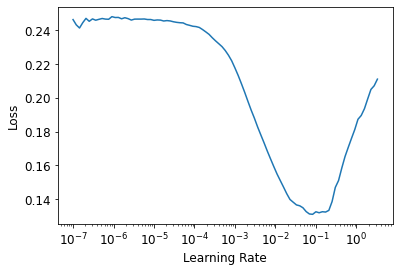

In [143]:
lrmin, lrsteep = learn2.lr_find()

In [144]:
learn2.fit_one_cycle(4, lrsteep)

epoch,train_loss,valid_loss,accuracy,time
0,0.221155,0.230381,0.637931,00:00
1,0.128251,0.215513,0.637931,00:00
2,0.078663,0.203386,0.637931,00:00
3,0.052891,0.188360,0.637931,00:00


In [145]:
learn2.unfreeze()

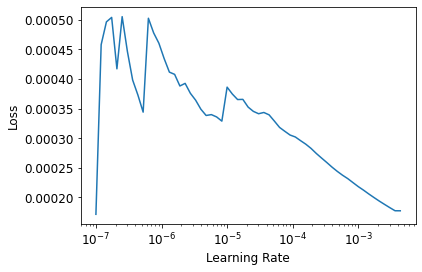

In [146]:
lrmin, lrsteep = learn2.lr_find()

In [147]:
learn2.fit_one_cycle(5, lr_max=slice(5e-4,lrsteep))

epoch,train_loss,valid_loss,accuracy,time
0,0.000321,0.169155,0.637931,00:00
1,0.000315,0.151308,0.637931,00:00
2,0.000318,0.146696,0.637931,00:00
3,0.000308,0.162714,0.637931,00:00
4,0.000401,0.193846,0.637931,00:00


In [148]:
X_train, y_train = to_nn.train.xs, to_nn.train.ys.values.ravel()
X_valid, y_valid = to_nn.valid.xs, to_nn.valid.ys.values.ravel()

In [64]:
X_valid.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket',
       'Cabin', 'Embarked', 'Age_na', 'Age', 'Fare'],
      dtype='object')

In [69]:
preds,targs = learn1.get_preds()


In [75]:
for i in range(len(preds)):
    if(preds[i] > 0.5):
        preds[i] = 1
    else:
        preds[i] = 0

In [76]:
accuracy_score(preds, targs)

0.8146551724137931

In [78]:
preds,targs = learn2.get_preds()
for i in range(len(preds)):
    if(preds[i] > 0.5):
        preds[i] = 1
    else:
        preds[i] = 0
        
accuracy_score(preds, targs)

0.7931034482758621

In [88]:
df_test['Fare'] = np.nan_to_num(df_test['Fare'] , copy=True)

In [89]:
test_dl = dls.test_dl(df_test)

In [156]:
class_score, y = learn2.get_preds(dl=test_dl)
for i in range(len(class_score)):
    if(class_score[i] > 0.5):
        class_score[i] = 1
    else:
        class_score[i] = 0
tmp = class_score.numpy()
tmp2 = tmp.astype(int)
labels = tmp2.reshape(418,)
labels

In [172]:
output= pd.DataFrame({'PassengerId':df_test.PassengerId, 'Survived': labels})
# output.to_csv('submission_nar2_titanic.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
